## Demonstrating Object-centric Causal nets by Merging Different Object Types C-nets with a Running Example

This notebook shows a running example of the discovery and visualization of an Object-centric Casual nets as presented in the paper 'Towards Discovering Object-centric Causal-Nets'.

### Pre-requisites

Please install the libraries mentioned in the file requirements.txt
You can do it by using pip install -r requirements.txt 

In [39]:
import pm4py
# import processmining

from discover_occnets import *
from view_occnets import *

In [40]:
file_path = './runningExample.sqlite'

### Model Discovery

The approach introduced in the paper uses the discovery of Causal nets for each object type and then merges them. This running example is based on an order management process found in an OCEL 2.0 event log. First, let us view the process model when including all object types.

In [41]:
ot_activities, ot_seq, subgraphs = subgraphs_dict(file_path)

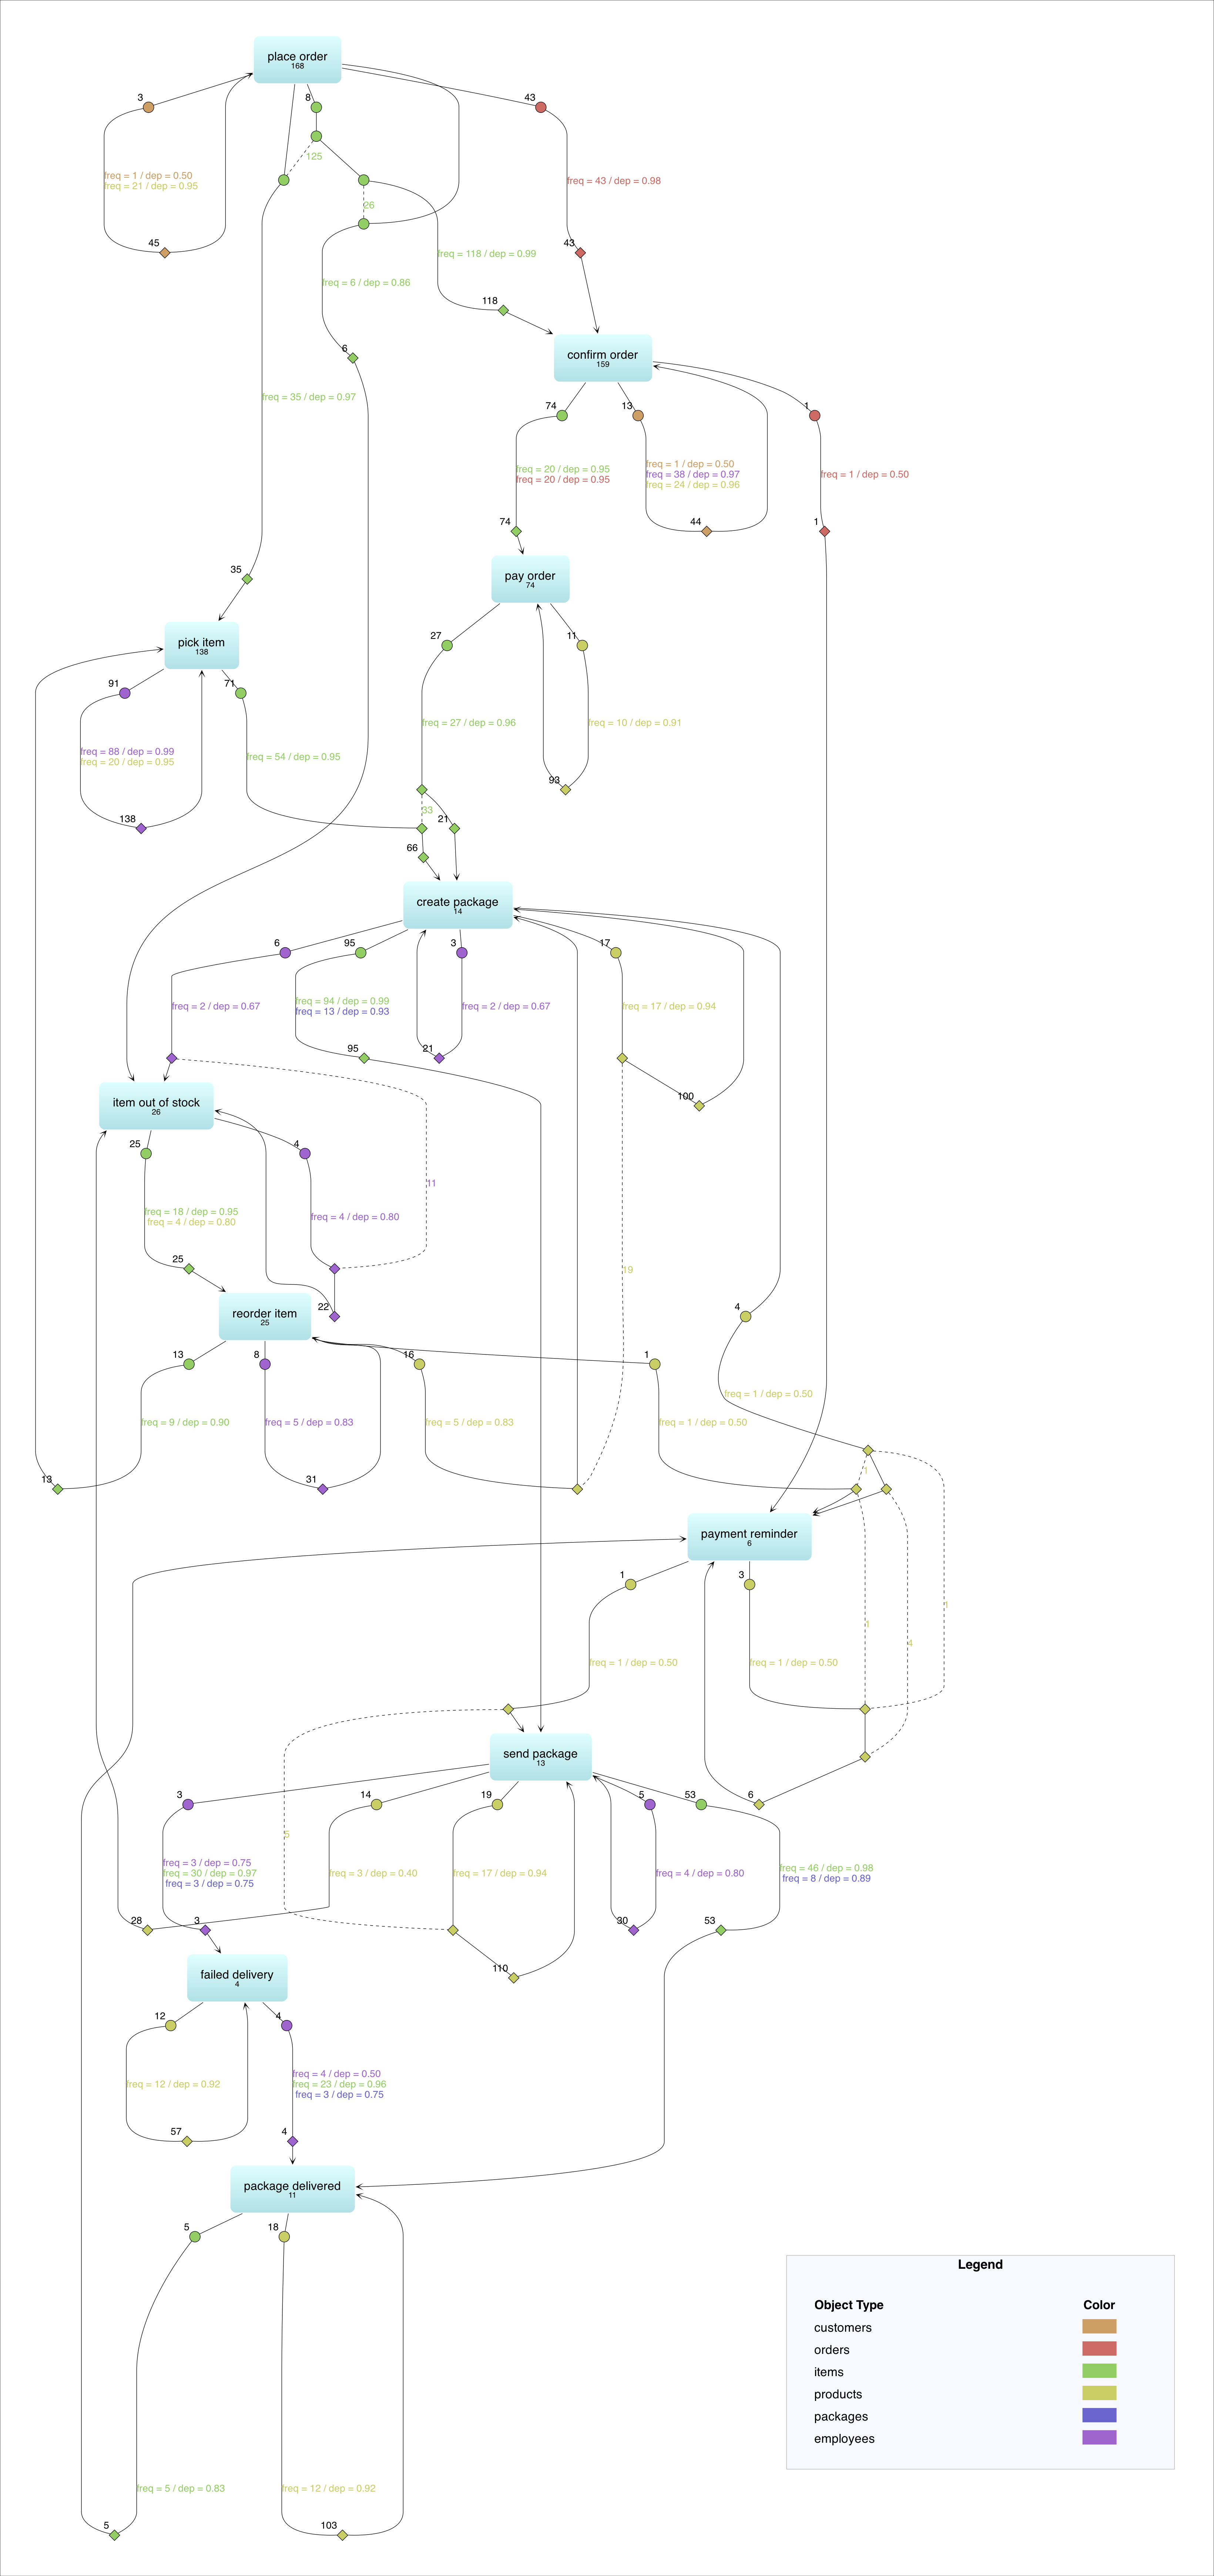

In [42]:
OCCN_model = all_ot_visualization(ot_activities, ot_seq, subgraphs)

Now, we illustrate how to discover Causal nets for an object type. Here, we choose the object type 'items'. These are the activities related to this object type.

In [43]:
print(ot_activities['items'])

{'package delivered', 'item out of stock', 'send package', 'confirm order', 'failed delivery', 'place order', 'reorder item', 'create package', 'pay order', 'pick item', 'payment reminder'}


First, we flatten and read the log. This allows us to have all activities related to the object type identified by the 'item' object ID and discover their traces, which is the sequence of activities for each object in the log. Let us see what the trace for item 'i-880001' looks like.

In [44]:
ocel, ot_activities, event_to_obj, obj_to_obj = import_log(file_path)
flt = flatten_log(ocel, ot_activities)
flt_items = flt['items']
logs = read_log(flt)
logs_items = logs['items']
all_traces = traces(flt)
ot_traces = all_traces['items']

Let us see how the trace for item 'i-880001' looks like.

In [45]:
print(ot_traces['i-880001'])

['place order', 'pick item', 'confirm order', 'pay order', 'create package', 'send package', 'package delivered']


It shows all activities realized for item 'i-880001' in the order in which they happened. This is possible due to activity timestamps in the log. Next, we want to count some frequencies. As shown in the model, each activity has its corresponding total count. Also, the frequency one activity is followed by another activity is counted because it allows us to calculate the dependency between them. In addition, we discover the start and end activities for the object type 'items'.

In [46]:
act_total = activity_total(logs['items'])
activities = activity_frequencies(logs_items)
or_start = original_start(act_total, activities)
or_end = original_end(act_total, activities)
freq = frequencies(activities)

Let us check how the frequency matrix for object type 'items' looks like.

In [47]:
print()
print('FREQUENCY MATRIX')
print()
print(freq)


FREQUENCY MATRIX

                   pick item  confirm order  item out of stock  place order  \
place order             35.0          118.0                6.0          0.0   
pick item                0.0           34.0                0.0          0.0   
confirm order           85.0            0.0               20.0          0.0   
pay order                8.0            0.0                0.0          0.0   
create package           1.0            0.0                0.0          0.0   
reorder item             9.0            1.0                0.0          0.0   
send package             0.0            1.0                0.0          0.0   
item out of stock        0.0            5.0                0.0          0.0   
package delivered        0.0            0.0                0.0          0.0   
payment reminder         0.0            0.0                0.0          0.0   
failed delivery          0.0            0.0                0.0          0.0   

                   payment remin

Now, we can proceed to calculate the dependencies between activities. If only frequency were considered, noise in the log could influence it, causing underfitting and admitting more behavior than it should in the model. However, the dependency measures prevent this from happening and are the fundamental variables on which Causal nets rely. We use three formulas to calculate the dependency measures. The first one relates two activities to one another; the second one relates one activity to itself (loops); and the third one relates two non-consecutive activities and helps determine if there is a long-distance causal relation between them. Let us see the dependency matrix for the object type 'items'.

In [48]:
dep = dependency_matrix(freq)
dep_dict = dependency_dict(dep)
long = long_distance_dependency(act_total, ot_traces, or_start, or_end)
print()
print('DEPENDENCY MATRIX')
print()
print(dep)


DEPENDENCY MATRIX

                  pick item confirm order item out of stock place order  \
place order        0.972222      0.991597          0.857143         0.0   
pick item               0.0        -0.425               0.0   -0.972222   
confirm order         0.425           0.0          0.576923   -0.991597   
pay order         -0.484848     -0.952381         -0.666667         0.0   
create package    -0.946429     -0.947368               0.0         0.0   
reorder item            0.9          -0.5         -0.947368         0.0   
send package           -0.5           0.5               0.0         0.0   
item out of stock       0.0     -0.576923               0.0   -0.857143   
package delivered       0.0           0.0               0.0         0.0   
payment reminder       -0.5           0.0               0.0         0.0   
failed delivery         0.0           0.0               0.0         0.0   

                  payment reminder create package pay order send package  \
pla

We consider a dependency measure of 0.95 or higher to build the dependency graph that serves as basis for the model. The dependency graph is composed of nodes and edges, where the nodes are the activities, and the edges are the arcs that connect one activity to another, showing the frequency and dependency relationships between them. When building the dependency graph, we need to avoid disconnected activities in the Causal nets model. This is achieved for each object type, but it is not always possible when there is more than one object type in the model because each object type has different start and end activities. To find the predecessor and successor activities of each activity, the dependency measure threshold is considered. This results in activities losing the race and potentially being disconnected in the Causal nets of an object type. To solve this, the next best predecessor is mined.

In [49]:
depgraph = dependency_graph(act_total, or_start, or_end, freq, dep, dep_dict, long, dependency_threshold=0.95)

Next, we use the dependency graph edges to discover the input and output arcs, that is, the predecessor and successor activities of each activity. By replaying the log in the arcs, we find the input and output bindings of each activity. This is the last step we need to take to discover the Causal nets of an object type.

In [50]:
# Generate the arcs based on the edges of the dep_graph
in_arcs = input_arcs(depgraph)
out_arcs = output_arcs(depgraph)

# Find the bindings in the incoming and outgoing arcs of the graph, using replay
cnet_outbindings = output_bindings(ot_traces, out_arcs, in_arcs)
cnet_inbindings = input_bindings(ot_traces, out_arcs, in_arcs) 

Let us discover the Causal nets of the object type 'items'. 

In [51]:
ot_nodes, ot_edges, i_seq, o_seq = ot_graph(depgraph, act_total, activities, dep_dict, cnet_inbindings, cnet_outbindings, seq_i=1, seq_o=1)
ot_subgraphs_dict = {'items': (ot_nodes, ot_edges)}
print(ot_subgraphs_dict)

{'items': (                 node        type             source             target  \
0         place order    activity                NaN                NaN   
1           pick item    activity                NaN                NaN   
2       confirm order    activity                NaN                NaN   
3           pay order    activity                NaN                NaN   
4      create package    activity                NaN                NaN   
5        send package    activity                NaN                NaN   
6   package delivered    activity                NaN                NaN   
7   item out of stock    activity                NaN                NaN   
8        reorder item    activity                NaN                NaN   
9    payment reminder    activity                NaN                NaN   
10    failed delivery    activity                NaN                NaN   
11                o_1  outbinding        place order      confirm order   
12            

However, this tabular representation is not ideal. So, in the next section, we will graphically visualize the complete model for selected object types.

### Model Visualization

We start by visualizing the 'items' object type Causal nets discovered in the previous section.

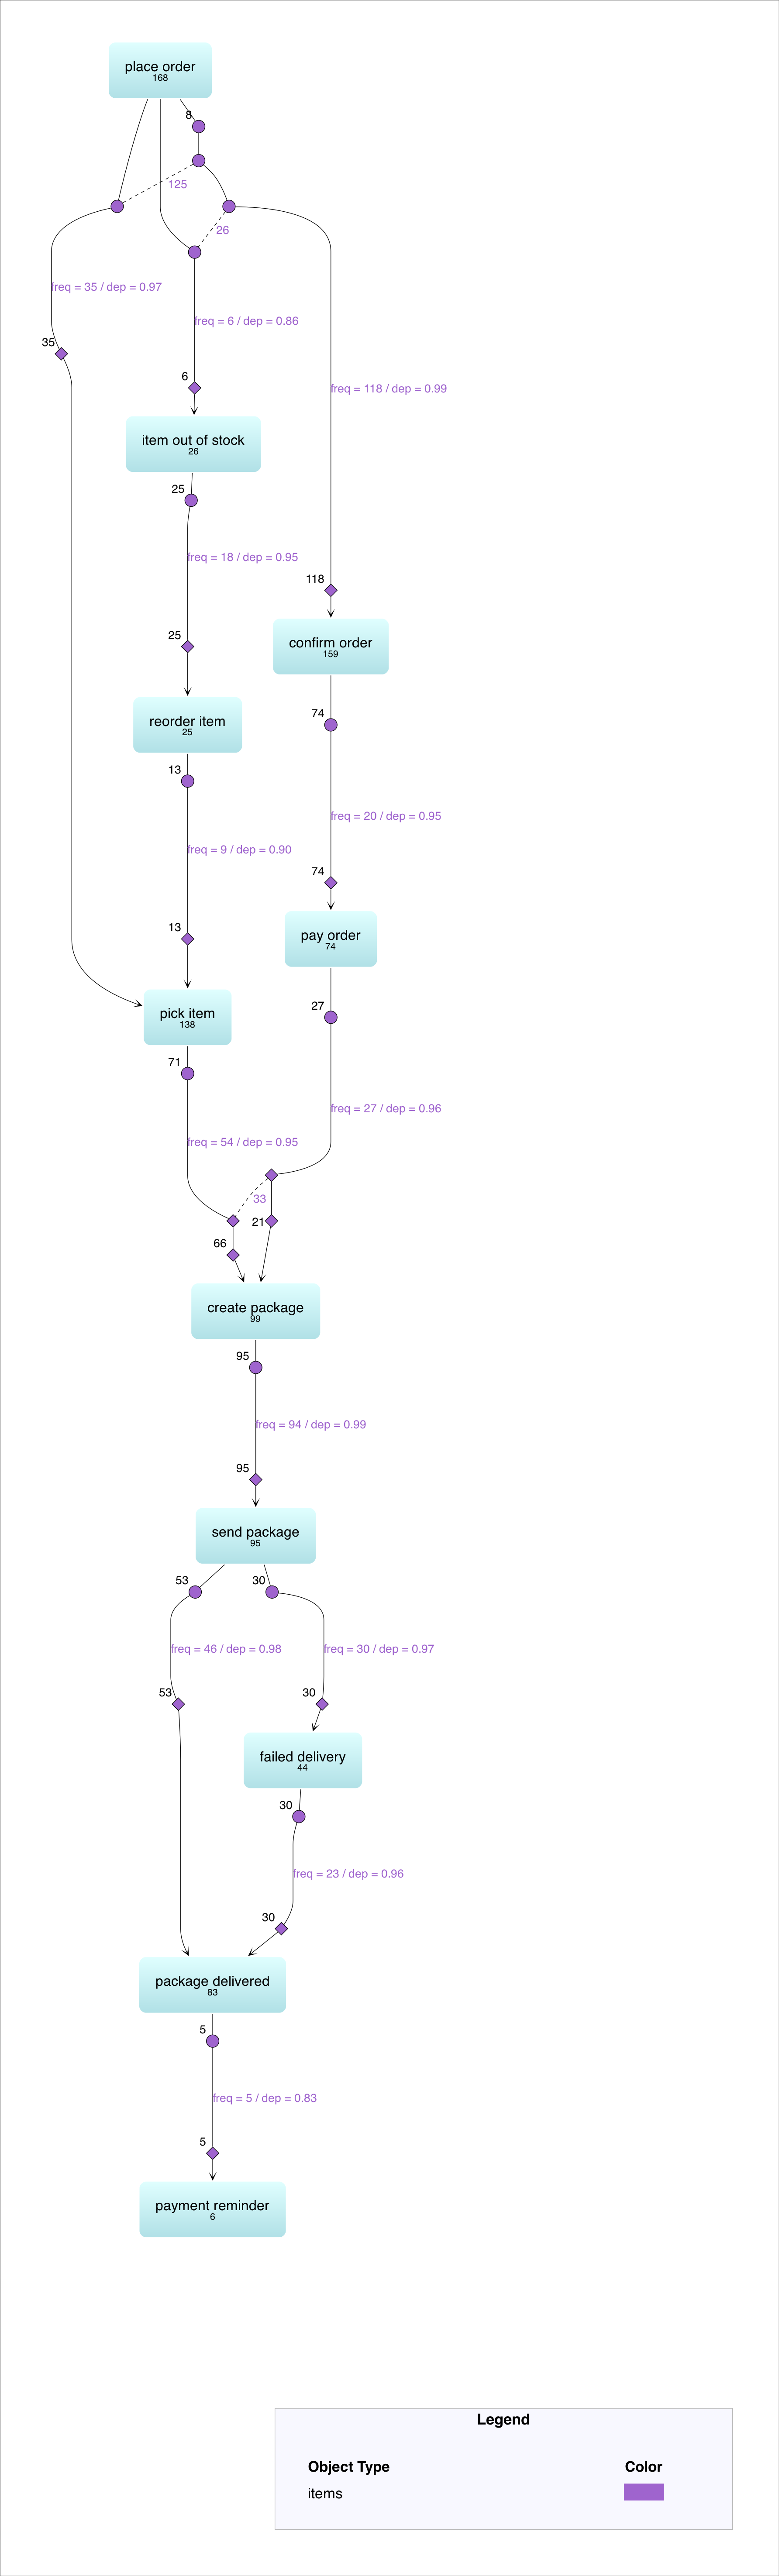

In [59]:
profile=['items']
cnets_items = all_ot_visualization(ot_activities, ot_seq, subgraphs, profile=profile)


However, in object-centric process mining, we are interested in the relationships between different object types. If all object types are included, the model can become cluttered and hinder the analysis. Thus, some object types are chosen, and their Causal nets are discovered and then merged to be presented in the model. For instance, let us select the object types 'orders', 'items', and 'packages'. Here, they are listed with their respective activities. 

In [74]:
for k,v in ot_activities.items():
    print(f"OT '{k}': activities {v}")  

OT 'customers': activities {'place order', 'confirm order'}
OT 'employees': activities {'package delivered', 'item out of stock', 'send package', 'confirm order', 'failed delivery', 'reorder item', 'create package', 'pick item'}
OT 'items': activities {'package delivered', 'item out of stock', 'send package', 'confirm order', 'failed delivery', 'place order', 'reorder item', 'create package', 'pay order', 'pick item', 'payment reminder'}
OT 'orders': activities {'pay order', 'place order', 'payment reminder', 'confirm order'}
OT 'products': activities {'package delivered', 'item out of stock', 'send package', 'confirm order', 'failed delivery', 'place order', 'reorder item', 'create package', 'pay order', 'pick item', 'payment reminder'}
OT 'packages': activities {'package delivered', 'send package', 'create package', 'failed delivery'}


To generate the model, we can define a profile, which is the list of object types we want to include in the visualization. If not defined, the model will include all object types encountered in the OCEL file. In our case, the profile = ['items', 'packages'] generates the following model.

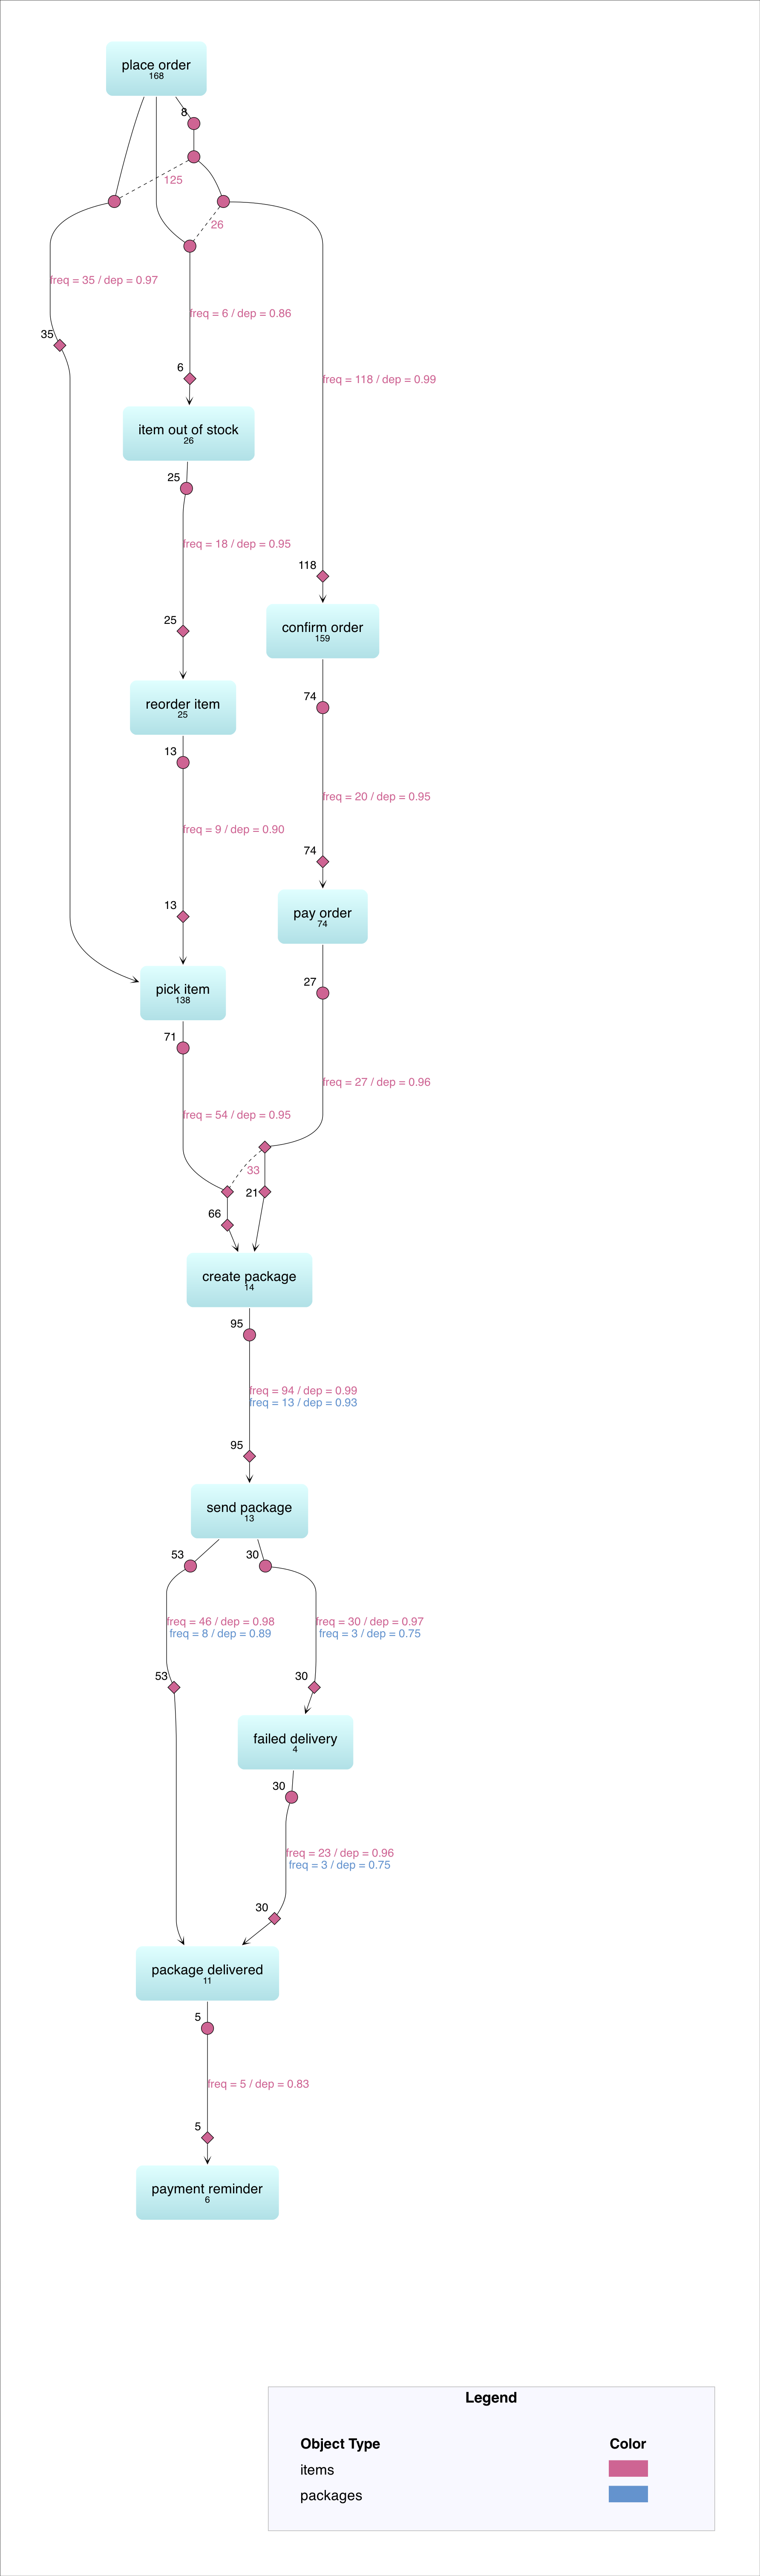

In [73]:
profile = ['items', 'packages']
OCCN_model = all_ot_visualization(ot_activities, ot_seq, subgraphs, profile=profile)

Note that activities {'package delivered', 'send package', 'create package', 'failed delivery'} are common to both object types. The edges are merged to be represented in the model, and the frequency and dependency measures of one activity followed by another are shown in different colors assigned to each object type, for clarity. This is done only for single bindings, as explained in the paper. Next, the nodes of merged edges are removed from the graph. The final step is to generate the model and create the legend for visualization.